In [ ]:
!pip install keras_applications

In [1]:
from numpy import load 
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
import datetime
from tensorflow import keras
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras import layers 
from os import name
from keras.layers import Concatenate
from keras import applications
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras import optimizers
from keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
data = load('G:/4 lead/4 lead aVR V1 V3 aVF train.npz') 
train_X = data['arr_0'] 
print('Loaded: ', train_X.shape)

Loaded:  (34064, 128, 128, 3)


In [3]:
data = load('G:/4 Lead/4 lead aVR V1 V3 aVF test.npz') 
test_X = data['arr_0'] 
print('Loaded: ', test_X.shape) 

Loaded:  (8520, 128, 128, 3)


In [4]:
data = load('G:/4 lead/y_train.npz', allow_pickle=True) 
train_y = data['arr_0'] 
print('Loaded: ', train_y.shape) 

Loaded:  (8516, 1)


In [5]:
data = load('G:/4 lead/y_test.npz', allow_pickle=True)
test_y = data['arr_0']
print('Loaded: ', test_y.shape) 

Loaded:  (2130, 1)


In [6]:
data=load("F:/denoised/split/I/mlp/train_X_dia.npz")
mlp_train_X=data['arr_0']
print('loaded', mlp_train_X.shape)

loaded (8516, 11)


In [7]:
data=load("F:/denoised/split/I/mlp/train_y_dia.npz")
mlp_test_X=data['arr_0']
print('loaded', mlp_test_X.shape)

loaded (2130, 11)


In [8]:
training_data = np.vsplit(train_X, 4) 

In [9]:
for i in range(4):
    print(training_data[i].shape) 

(8516, 128, 128, 3)
(8516, 128, 128, 3)
(8516, 128, 128, 3)
(8516, 128, 128, 3)


In [10]:
np.shape(training_data)

(4, 8516, 128, 128, 3)

In [11]:
testing_data = np.vsplit(test_X, 4) 

In [12]:
for i in range(4):
    print(testing_data[i].shape)

(2130, 128, 128, 3)
(2130, 128, 128, 3)
(2130, 128, 128, 3)
(2130, 128, 128, 3)


In [13]:
np.shape(testing_data) 

(4, 2130, 128, 128, 3)

In [14]:
train_y=pd.DataFrame(train_y, columns=[ 'Rhythm'])
test_y=pd.DataFrame(test_y, columns=[ 'Rhythm'])

In [15]:
label = LabelEncoder()
train_y['label'] = label.fit_transform(train_y['Rhythm'])

In [16]:
test_y['label'] = label.fit_transform(test_y['Rhythm'])

In [17]:
train_y=train_y.drop([ 'Rhythm'], axis=1)
test_y=test_y.drop([ 'Rhythm'], axis=1)

In [18]:
y_train=to_categorical(train_y) 
y_test=to_categorical(test_y) 

In [19]:
base_model=tf.keras.applications.DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=(128,128,3)
)

In [20]:
base_model.trainable = False

In [21]:
# dataset has 4 classes
num_class = 4

In [22]:
def conv_block_2d():
        preprocess = tf.keras.layers.experimental.preprocessing.Rescaling(
            scale=1.0/127.5,
            offset=-1)
        inputs = layers.Input(shape=(128, 128, 3))
        x = preprocess(inputs)
        x =base_model(x, training=False)
        output = layers.GlobalAveragePooling2D()(x)
        return inputs, output 

In [23]:
def multiple_cnn2D(nb):
  inputs = []
  features = []
  for i in range(nb):
    input_2d, features_2d = conv_block_2d()
    inputs.append(input_2d)
    features.append(features_2d)

  x1 = layers.concatenate(features, axis=-1)
  x1= Dropout(.1)(x1)
  x1=Dense(32,activation='relu')(x1)
  x1= Dropout(0.2)(x1)

  x2 = Sequential()
  mlp_input = Input(shape=(11,), name='mlp')
  x2=Dense(128, activation='relu')(mlp_input)
  
  concat = layers.concatenate([x1,x2])
  preds=Dense(num_class, activation='softmax')(concat) #final layer with softmax activation
  
  model=Model(inputs=[inputs, mlp_input],outputs=preds)
  opt = Adam(lr=0.00003) 
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  print(model.summary())
  return model

In [24]:
model = multiple_cnn2D(4)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                            

C:\Users\ASUS\.conda\envs\Tensorflow\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

In [26]:
#lead aVR
history = model.fit([training_data, mlp_train_X], y_train, epochs = 430, batch_size=64, validation_data= ([testing_data, mlp_test_X], y_test), callbacks=callback)

Epoch 1/430
134/134 [==============================] - 102s 507ms/step - loss: 0.9771 - accuracy: 0.6190 - val_loss: 0.6598 - val_accuracy: 0.8150
Epoch 2/430
134/134 [==============================] - 59s 442ms/step - loss: 0.6096 - accuracy: 0.8070 - val_loss: 0.4815 - val_accuracy: 0.8671
Epoch 3/430
134/134 [==============================] - 60s 448ms/step - loss: 0.4971 - accuracy: 0.8408 - val_loss: 0.4149 - val_accuracy: 0.8836
Epoch 4/430
134/134 [==============================] - 59s 443ms/step - loss: 0.4493 - accuracy: 0.8571 - val_loss: 0.3805 - val_accuracy: 0.8850
Epoch 5/430
134/134 [==============================] - 62s 464ms/step - loss: 0.4211 - accuracy: 0.8664 - val_loss: 0.3591 - val_accuracy: 0.8911
Epoch 6/430
134/134 [==============================] - 62s 467ms/step - loss: 0.3933 - accuracy: 0.8764 - val_loss: 0.3436 - val_accuracy: 0.8934
Epoch 7/430
134/134 [==============================] - 87s 650ms/step - loss: 0.3806 - accuracy: 0.8803 - val_loss: 0.3321 

In [27]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='lower right')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

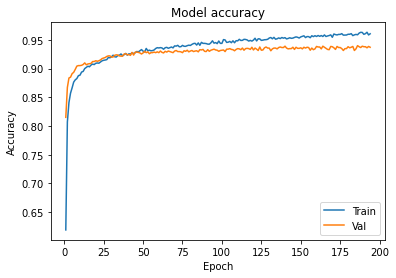

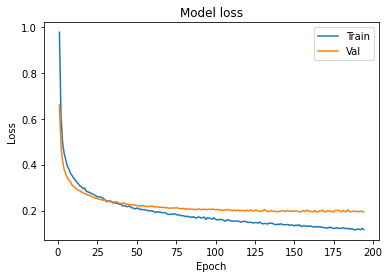

In [28]:
plot_learningCurve(history, 194)

In [29]:
preds = model.predict([testing_data, mlp_test_X])

In [30]:
classes_x=np.argmax(preds,axis=1)
rounded_labels=np.argmax(y_test, axis=1)

In [31]:
import sklearn.metrics as metrics

In [33]:
import seaborn as sns

In [34]:
def confusion_matrix(y, y_pred):
    labels=[ 'AFIB','GSVT', 'SB', 'SR']
    matrix = metrics.confusion_matrix(y, y_pred)
    plt.figure(figsize=(9, 6))
    ax= sns.heatmap(matrix, cmap='coolwarm', linecolor='white', linewidths=1, xticklabels=labels, yticklabels=labels, annot=True, fmt='d')
    #bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

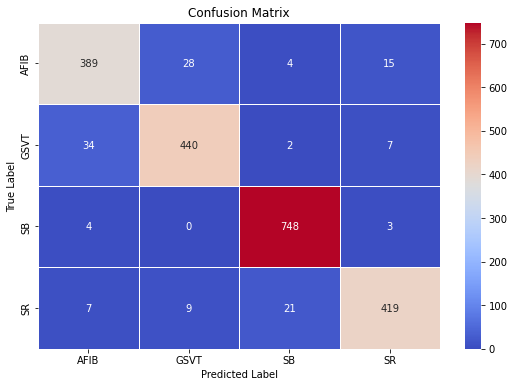

In [35]:
confusion_matrix(rounded_labels, classes_x)

In [36]:
from sklearn.metrics import classification_report

In [37]:
print(classification_report(rounded_labels, classes_x))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89       436
           1       0.92      0.91      0.92       483
           2       0.97      0.99      0.98       755
           3       0.94      0.92      0.93       456

    accuracy                           0.94      2130
   macro avg       0.93      0.93      0.93      2130
weighted avg       0.94      0.94      0.94      2130

